# TP 3 Reinforcement Learning

Pierre-Louis Guhur pierre-louis.guhur@ens-paris-saclay.fr


***Q1:* Implement REINFORCE with Gaussian policy model.**

REINFORCE [Williams, 1982] is a gradient ascent algorithm that maximises the policy performance. The policy performance is written as the expected reward over the trajectory.


100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


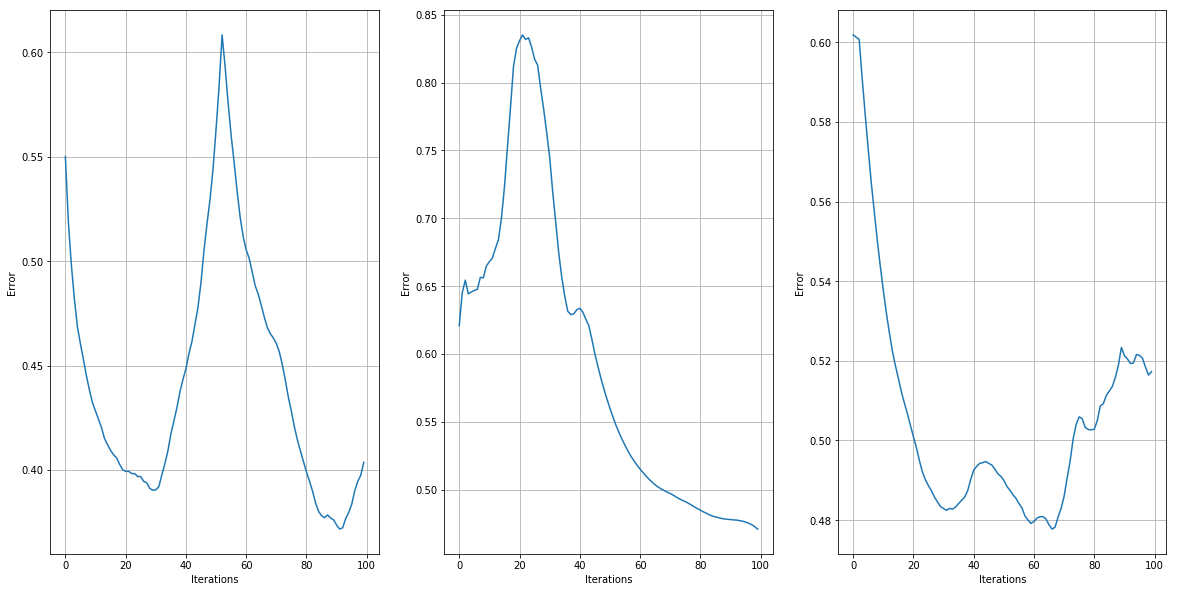

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lqg1d import LQG1D 
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
from utils import collect_episodes

        
class GaussianPolicy():
    
    def __init__(self, theta):
        self._sigma = 0.4
        self.theta = theta
    
    def sigma(self, state):
        return self._sigma
    
    def grad_mu(self, state):
        return state
    
    def mu(self, state):
        return self.theta * state
    
    def grad_log(self, action, state):
        return (action-self.mu(state))/self.sigma(state)**2*self.grad_mu(state)
        
    def draw_action(self, state):
        return self.sigma(state)*np.random.randn() + self.mu(state)
    
    def gradient_based_update(self, simulator, gamma=0.9, n_episodes=20, T=100, **kwargs):
        """ Estimate the gradient from a Monte-Carlo simulation """
        acc = 0.0
        paths = collect_episodes(simulator, policy=self, horizon=T, n_episodes=n_episodes)
        for path in paths:
            actions, states, rewards = path['actions'], path['states'], path['rewards']
            acc += np.sum(self.grad_log(actions, states)*rewards)
        return acc/n_episodes
                
#     def cumulated_reward(self, rewards, gamma=0.9):
#         return np.sum(gamma**np.arange(0, len(actions)) * rewards)
        


class AdamOptimizer():
    def __init__(self):
        self.m = 0
        self.v = 0
        self.t = 1
        
    def step(self, gradient, beta_1=0.9, beta_2=0.95, learning_rate=5e-2, eps=1e-8):
        """ Gradient descent optimizer """
        self.m = beta_1*self.m + (1-beta_1)*gradient
        self.v = beta_2*self.v + (1-beta_2)*gradient**2
        m_hat = self.m/(1-beta_1**self.t)
        v_hat = self.v/(1-beta_2**self.t)
        self.t += 1
        return learning_rate*m_hat/(np.sqrt(v_hat)+eps)

def REINFORCE(theta0, simulator, policy_model, optimizer, n_iter=100, **kwargs):
    """ Implementation of the REINFORCE algorithm """
    policy_model.theta = theta0
    thetas = np.zeros(n_iter)
    for t in tqdm(range(n_iter)):
        g = policy_model.gradient_based_update(simulator, **kwargs)
        policy_model.theta += optimizer.step(g)
        thetas[t] = policy_model.theta
    return thetas
        
        
simulator = LQG1D('fixed')
theta0 = 0
theta_opt = -0.6
policy_model = GaussianPolicy(theta0)
optimizer = AdamOptimizer()
n_trials = 3
plt.figure(figsize=(20,10))
for i in range(n_trials):
    plt.subplot(1, n_trials, i+1)
    theta = REINFORCE(theta0, simulator, policy_model, optimizer)
    errors = (theta - theta_opt)
    plt.plot(errors)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.grid()
plt.show()

***Q2:* Implement REINFORCE with exploration bonus and test it on the LQR domain.**

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


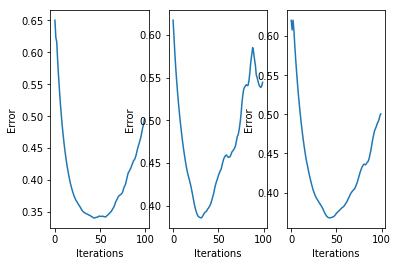

In [19]:
flatten = lambda list_: np.array(list_).flatten()


class GaussianPolicyWithBonus(GaussianPolicy):
      
    def __init__(self, *args):
        super().__init__(*args)
        self.beta = 1
        self.Nphi = lambda actions, states: np.clip( \
                            np.histogram2d(actions, states, density=False)[0], \
                            1, None)

    def exploration_bonus(self, actions, states, rewards):
        """ Exploration bonus on the reward """
        return self.beta*np.sqrt(1/self.Nphi(flatten(actions), flatten(states))).flatten() + rewards
        
    def gradient_based_update(self, simulator, gamma=0.9, n_traj=20, T=100, **kwargs):
        """ Estimate the gradient from a Monte-Carlo simulation by a bonus on the reward """
        acc = 0.0
        for n in range(1, n_traj):
            actions, states, rewards = simulation(T, self, simulator, **kwargs)
            rewards = self.exploration_bonus(actions, states, rewards)
            for k in range(0, len(actions)):
                acc += self.grad_log(actions[k], states[k])*rewards[k]
        return acc/n_traj
        
simulator = LQG1D('fixed')
theta0 = 0
theta_opt = -0.6
policy_model = GaussianPolicyWithBonus(theta0)
optimizer = AdamOptimizer()
n_trials = 3
n_iter = 100
plt.figure(figsize=(20,10))
for i in range(n_trials):
    plt.subplot(1, n_trials, i+1)
    theta = REINFORCE(theta0, simulator, policy_model, optimizer, n_iter=n_iter)
    errors = (theta - theta_opt)
    plt.plot(errors)
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.grid()
plt.show()

***Q3:* implement FQI with linear function approximation. The provided code contains the skeleton for the generation of the dataset but you have to define the behavioural policy. To evaluate the performance of the algorithm, after each update, you should simulate the policy for 50 episodes of length 50 in order to estimate $J(\pi_k)$. Plot $k\mapsto J(\pi_k)$.**

Optimal K: [[-0.58840335]] Covariance S: 0.001


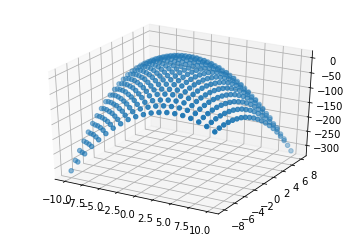

In [9]:
import numpy as np
from numpy.linalg import inv
from lqg1d import LQG1D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from utils import collect_episodes, estimate_performance

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

class BehavorialPolicy():
    
    def __init__(self, discrete_actions):
        self.discrete_actions = discrete_actions
        
    def draw_action(self, state):
        return np.random.choice(self.discrete_actions)
     
env = LQG1D(initial_state_type='random')
discount = 0.9
horizon = 50

actions = discrete_actions = np.linspace(-8, 8, 20)
states = discrete_states = np.linspace(-10, 10, 20)
SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]
K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))
Q_fun_ = np.vectorize(lambda s, a: 
                        env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])
Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)
plt.show()

# Collect the samples
beh_policy = BehavorialPolicy(discrete_actions)
dataset = collect_episodes(env, n_episodes=100,
                            policy=beh_policy, horizon=horizon)

In [75]:
# Test FQI
class FQI:
    
    def __init__(self, dataset, n_a, n_s, horizon, gamma=0.9):
        self.actions = np.concatenate([p['actions'] for p in dataset])
        self.states = np.concatenate([p['states'] for p in dataset])
        self.rewards = np.concatenate([p['rewards'] for p in dataset])
        self.next_states = np.concatenate([p['next_states'] for p in dataset])
        self.n_s, self.n_a = n_s, n_a
        self.horizon = horizon
        self.Q = np.ones((self.n_s, self.n_a))
        self.phi = lambda action, state: \
                        np.array([action, state*action, state**2 + action**2])
        self.gamma = gamma
        self.K = 10
        self.lambda_= 1e-2
        self.fitted_q_iterations()
        
    def s2i(self, state):
        """ Convert a state into a indice in Q """
        return np.int_((state + 20)/self.n_s)
    
    def a2i(self, state):
        """ Convert an action into a indice in Q """
        return np.int_((state + 40)/self.n_a)
    
    def compute_Z(self):
        return self.phi(self.actions, self.states).T

    def compute_y(self):
        slice_Q = self.Q[self.s2i(self.next_states[:]), :]
        return self.rewards + self.gamma*np.max(slice_Q, axis=1)  
    
    def fitted_q_iterations(self):
        thetas = np.zeros((self.K, 3))
        Z = self.compute_Z()
        for k in range(self.K):
            y = self.compute_y()
            thetas[k, :] = inv(Z.T.dot(Z) + self.lambda_*np.eye(3)).dot(Z.T).dot(y)
            # update Q
            for i, action in enumerate(np.arange(-40, 40, self.n_a)):
                for j, state in enumerate(np.arange(-20, 20, self.n_s)):
                    self.Q[j, i] = self.phi(action, state).dot(thetas[k])
        return thetas
            
    def draw_action(self, state):
        return np.argmax(self.Q[self.s2i(state), :])
       
    
fqi = FQI(dataset, 20, 20, horizon)
J = estimate_performance(env, policy=fqi, horizon=horizon, n_episodes=500, gamma=discount)
print('Policy performance: {}'.format(J))


100%|██████████| 500/500 [00:00<00:00, 32627.80it/s]

Policy performance: -1398.112718351813
